In [1]:
import os, sys, glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
import lightkurve as lk
import pickle
from astropy.wcs import WCS
from astropy.io import fits

%matplotlib inline
path = os.path.dirname(os.getcwd()) 

sys.path.append(path)
from exba import EXBA
from exba.utils import solve_linear_model

lk.__version__

'2.0.3.dev'

# EXBA

In [2]:
quarter = 5
Q = 5
CH = 44
channels = np.sort(np.array(os.listdir('%s/data/EXBA/' % path), dtype=int))
print(channels)

[ 1  2  3  4  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84]


In [3]:
exbas = []
for ch in channels:
    if ch != CH: continue
    exba = EXBA(channel=ch, quarter=quarter)
    exbas.append(exba)

TargetPixelFileCollection of 4 objects:
	100002227 (1 KeplerTargetPixelFiles) Quarters: 5
	100002228 (1 KeplerTargetPixelFiles) Quarters: 5
	100002229 (1 KeplerTargetPixelFiles) Quarters: 5
	100002230 (1 KeplerTargetPixelFiles) Quarters: 5

Loading query from file...
/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/EXBA/44/5/gaia_xmatch_query_result.csv


In [5]:
fluxes = np.array([x.flux[0].value for x in exbas]).ravel()

In [6]:
rows_2d, cols_2d, ras_2d, decs_2d, flux_2d = [], [], [], [], []
for exba in exbas:
    rows_2d.append(exba.col_2d)
    cols_2d.append(exba.row_2d)
    ras_2d.append(exba.ra_2d)
    decs_2d.append(exba.dec_2d)
    flux_2d.append(exba.flux_2d[0])
    
rows_2d = np.array(rows_2d)[0]
cols_2d = np.array(cols_2d)[0]
ras_2d = np.array(ras_2d)[0]
decs_2d = np.array(decs_2d)[0]
flux_2d = np.array(flux_2d)[0]
wcss = np.array([x.tpfs[0].wcs for x in exbas])[0]

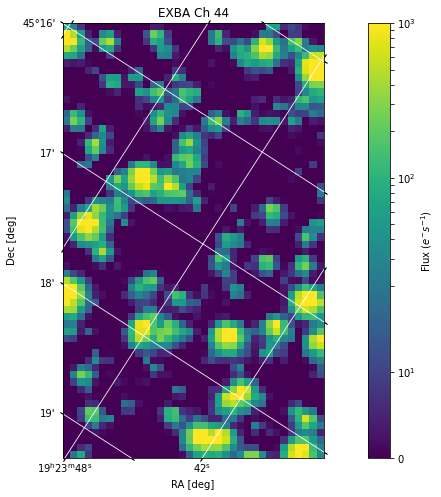

In [8]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(projection=wcss) 
im = ax.imshow(flux_2d, cmap=plt.cm.viridis, origin='lower',
               norm=colors.SymLogNorm(linthresh=20, vmin=0, vmax=1000, base=10))
fig.colorbar(im, label=r"Flux ($e^{-}s^{-1}$)")

plt.title('EXBA Ch %i' % (CH))
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.grid(color='white', ls='solid')
ax.set_aspect("equal", adjustable="box")

plt.show()

# FFI

In [9]:
fits_list = np.sort(glob.glob("%s/data/ffi/%i/kplr*_ffi-cal.fits" % (path, Q)))
test_file = fits_list[1]
print(test_file)
hdr = fits.open(test_file)[CH].header
img = fits.open(test_file)[CH].data
wcs = WCS(hdr)

print(img.shape)
print(wcs)

/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/5/kplr2010140101631_ffi-cal.fits
(1070, 1132)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 290.94950673436256  45.37117973704275  
CRPIX : 533.0  521.0  
CD1_1 CD1_2  : -0.000928479528346  0.0005990385319241923  
CD2_1 CD2_2  : -0.0005986339574474  -0.0009282023218424  
NAXIS : 1132  1070


In [10]:
r_min, r_max = 20, 1044
c_min, c_max = 12, 1112
ffi = img[r_min:r_max, c_min:c_max]

In [12]:
ffi_sources = pd.read_csv("%s/data/ffi/%i/channel_44_gaia_xmatch_clean.csv" % (path, Q))

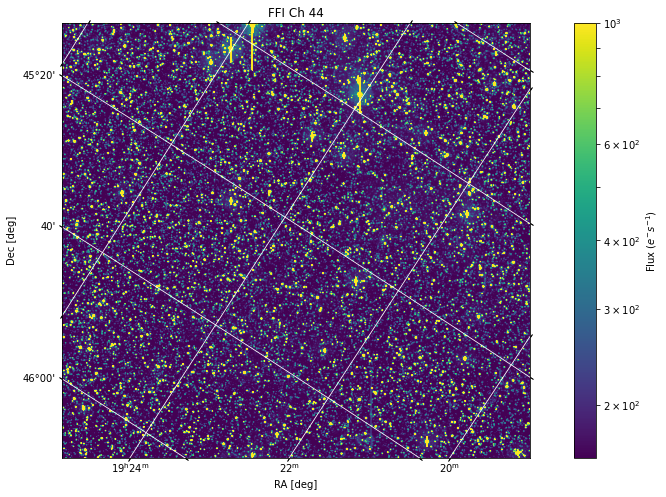

In [13]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(projection=wcs) 
im = ax.imshow(ffi, cmap=plt.cm.viridis, origin='lower',
               norm=colors.SymLogNorm(linthresh=20, vmin=160, vmax=1000, base=10))
fig.colorbar(im, label=r"Flux ($e^{-}s^{-1}$)")

plt.title('FFI Ch %i' % (CH))
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.grid(color='white', ls='solid')
ax.set_aspect("equal", adjustable="box")

#ax.scatter(ffi_sources.ra, ffi_sources.dec, 
#               facecolors='none', edgecolors='r', linewidths=1,
#               transform=ax.get_transform('icrs'))

plt.show()

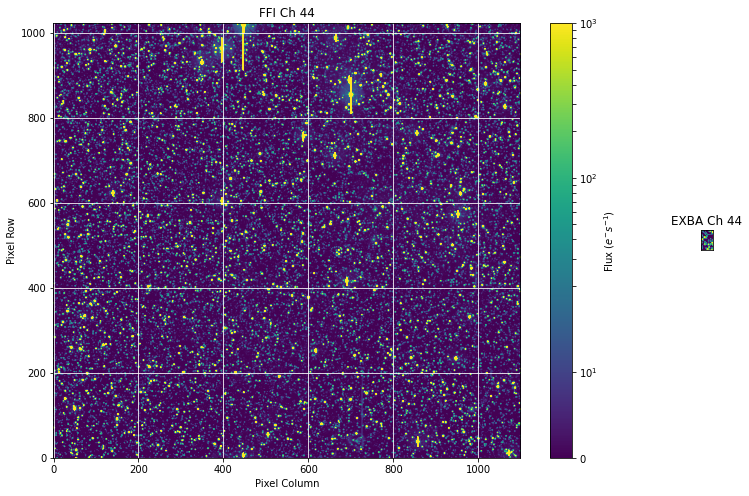

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,8), 
                       #subplot_kw={"projection": wcs},
                       gridspec_kw={'width_ratios': [100, 2]})

im = ax[0].imshow(ffi, cmap=plt.cm.viridis, origin='lower',
               norm=colors.SymLogNorm(linthresh=20, vmin=160, vmax=2000, base=10))
#fig.colorbar(im, label=r"Flux ($e^{-}s^{-1}$)", ax=ax[0])

ax[0].set_title('FFI Ch %i' % (CH))
ax[0].set_xlabel('Pixel Column')
ax[0].set_ylabel('Pixel Row')
ax[0].grid(color='white', ls='solid')
#ax[0].set_aspect("equal", adjustable="box")

im = ax[1].imshow(flux_2d, cmap=plt.cm.viridis, origin='lower',
               norm=colors.SymLogNorm(linthresh=20, vmin=0, vmax=1000, base=10))
fig.colorbar(im, label=r"Flux ($e^{-}s^{-1}$)", ax=ax[0])

#ax[1].grid(color='white', ls='solid')
ax[1].set_aspect("equal", adjustable="box")
ax[1].set_title('EXBA Ch %i' % (CH))
#ax[1].set_xlabel('')
#ax[1].set_ylabel('')
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

In [116]:
for ch in range(len(flux_2d)):
    fig = plt.figure(figsize=(16,8))
    ax = plt.subplot(projection=wcss[ch]) 
    im = ax.imshow(flux_2d[ch], cmap=plt.cm.viridis, origin='lower',
                   norm=colors.SymLogNorm(linthresh=20, vmin=0, vmax=1000, base=10))
    fig.colorbar(im, label=r"Flux ($e^{-}s^{-1}$)")

    plt.title('EXBA Ch %i with Gaia DR2 Sources' % (channels[ch]))
    ax.set_xlabel('RA [deg]')
    ax.set_ylabel('Dec [deg]')
    ax.grid(color='white', ls='solid')
    
    ax.scatter(exbas[ch].sources.ra, exbas[ch].sources.dec, 
               facecolors='none', edgecolors='r', linewidths=1,
               transform=ax.get_transform('icrs'))
    
    plt.savefig("%s/figures/EXBA_Q%i_Ch%i.png" % 
                (path, quarter, channels[ch]), format="png",
                bbox_inches='tight')
    
    #plt.show()
    plt.clf()
    ptl.close()
    
    #if ch == 2: break

<ipython-input-116-902c8cc31e2a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16,8))


<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>